In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from embeddings.dataloader import TheDataSet
%matplotlib inline
import matplotlib.pyplot as plt
# import tensorboard
# from tensorboard import SummaryWriter



In [3]:
encoder_training_epochs = 500
# dataset_file = 'data_ae_train/fulldata.npy'
# dataset_file = 'data/fulldata.npy'
dataset_file = 'data/autoencoder_fulldata.npy'
# dataset_file = 'data/autoencoder_fulldata_mini.npy'

# dataset_file = 'data/labdata.npy'

In [4]:
mxxx = np.load(dataset_file)

In [5]:
mxxx.shape, np.max(mxxx), np.min(mxxx)

((54871, 1338), 1.0, 0.0)

In [6]:
del mxxx

In [6]:
# default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter(f"runs/autoencoder_experiment_{encoder_training_epochs}")


## AutoEncoder


In [7]:
%%writefile embeddings/autoencoder.py

# d=64
import torch
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=num_features // 2 , bias=True),
            nn.Dropout(p = 0.1),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=64, out_features=128, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=num_features // 2, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=num_features, bias=True ),
            #nn.Sigmoid()
            nn.ReLU()
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Overwriting embeddings/autoencoder.py


In [8]:
%%writefile embeddings/autoencoder.py

# d= 128
import torch
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=num_features // 2 , bias=True),
            nn.Dropout(p = 0.1),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=256, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=256, out_features=num_features // 2, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=num_features, bias=True ),
            #nn.Sigmoid()
            nn.ReLU()
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Overwriting embeddings/autoencoder.py


In [3]:
%%writefile embeddings/autoencoder.py

import torch
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=128 , bias=True),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.Tanh(),
#             nn.Linear(in_features=64, out_features=32, bias=True),
#             nn.Tanh()
        )
        self.decoder = nn.Sequential(
#             nn.Linear(in_features=32, out_features=64, bias=True),
#             nn.Tanh(),
            nn.Linear(in_features=64, out_features=128, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=num_features, bias=True ),
            #nn.Sigmoid()
            nn.Tanh()
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Overwriting embeddings/autoencoder.py


In [9]:
from embeddings.autoencoder import Autoencoder

## Training

In [10]:
def train(model, dataset, num_epochs=5, batch_size=64, learning_rate=1e-3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
#     criterion = nn.L1Loss()
#     criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    outputs = []
    losses = []
    for epoch in range(num_epochs):
        for X, y in train_loader:
            X = X.to(device)
            recon = model(X.float())
            loss = criterion(recon, X.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        losses.append(float(loss))
#         writer.add_scalar(f'training loss {num_epochs}',
#                             loss,
#                             epoch * len(train_loader))
        # stop training if loss is low
        if loss < 0.0050:
            break
    return outputs, losses

In [11]:
dataset = TheDataSet(datafile=dataset_file, pad_to_360=False)
print(f"dataset length = {len(dataset)} num features = {dataset.num_features()}")
model = Autoencoder(num_features=dataset.num_features())
print(model)
max_epochs = encoder_training_epochs

dataset length = 54871 num features = 1337
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1337, out_features=668, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=668, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=668, bias=True)
    (3): ReLU()
    (4): Linear(in_features=668, out_features=1337, bias=True)
    (5): ReLU()
  )
)


In [ ]:
%%time
outputs, losses = train(model, dataset=dataset, num_epochs=max_epochs, batch_size = 512, learning_rate=1e-3)

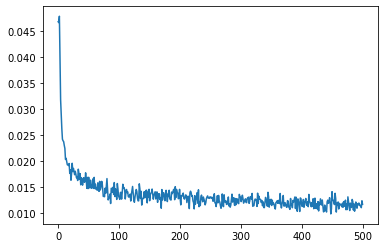

In [13]:
fig = plt.figure()
ax = plt.axes()

# x = np.linspace(0, 10, 1000)
ax.plot(losses);

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = TheDataSet(datafile='data/fulldata.npy', pad_to_360=False)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
rows=[]
for X, y in data_loader:
    X = X.to(device)
    y = y.to(device)
    row = model.encoder(X.float())
    row = torch.cat([row.reshape(1,-1),y.reshape(1,-1).float()], dim=1)
    rows.append(row)

In [17]:
len(rows)

4085

In [18]:
encoded_data = torch.cat(rows, dim=0)

In [19]:
np_labeled_data = encoded_data.detach().to('cpu').numpy()

In [20]:
np.save('data/np_autoencoded_labeled_data.npy', np_labeled_data)

In [34]:
row.reshape(1,-1).shape, torch.cat([row.reshape(1,-1),y.reshape(1,-1).float()], dim=1)

(torch.Size([1, 65]),
 tensor([[ 0.1479, -0.2890, -0.5155, -0.3377, -0.1543,  0.9087,  0.3199, -0.0341,
          -0.6982,  0.9970,  0.3223, -0.0421, -0.2520,  0.6466, -0.0977,  0.2991,
           0.8181,  0.4294, -0.0431, -0.3838,  0.9970,  0.6513, -0.9836,  0.9970,
           0.2387, -0.9970,  0.9970, -0.1760, -0.5356, -0.8139, -0.4584, -0.3392,
           0.0995,  0.9159, -0.9970,  0.0716, -0.1129,  0.4067,  0.9970, -0.4828,
           0.8070,  0.1122,  0.0312, -0.9970,  0.0856, -0.1463, -0.9970,  0.3189,
           0.8918,  0.1904,  0.9970, -0.9951, -0.5434,  0.1786, -0.7900, -0.5141,
           0.3048, -0.8398, -0.9355,  0.1171,  0.8686,  0.2800,  0.4023, -0.3393,
           0.0000,  0.0000]], device='cuda:0', grad_fn=<CatBackward>))

In [ ]:
import numpy as np
np.save()

In [41]:
min(losses)

0.009168824180960655

In [14]:
# persist the encoder


with open('data/autoencoder.pic', 'bw') as f:
    torch.save(model, f, pickle_protocol=4)




In [10]:
with open('data/autoencoder.pic', 'rb') as f:
    autoencoder = torch.load(f)